In [1]:
%%html
<style>div.output_area{ padding-left:20px; }</style>

### Pontifícia Universidade Católica do Rio de Janeiro
### Álgebra Linear Para Data Science e Machine Learning - P2
#### **Nome**: Alysson Gomes
#### **Matrícula**: 1812766

In [4]:
import math
import numpy as np
import pandas as pd
from scipy import linalg
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import * #funções de similaridade
from scipy.spatial.distance import euclidean
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize, LabelBinarizer
from tqdm import tqdm

### Building Graph

Estratégias de construção do grafo:
* k-nearest neighbor
* ε-neighborhood
* fully connected

In [6]:
def k_nearest_neighbor(matrix, k):
    """
        Parameters:
            matrix_similarity: matriz de similaridade ou de distâncias calculada externamente
            k: quantidade de vizinhos de cada vértice
        Return:
            W: matriz de adjacência cujos os valores correspondem a similaridade
            D: matriz de graus cujos os valores é soma das similaridade
    """
    W = np.zeros(matrix.shape)
    D = np.zeros(matrix.shape)
    
    """
    type_: distingue entre matriz de distância e matriz de similaridade
        1 = distância
        2 = similaridade
    """
    type_ = 1
    if matrix[0][0] == 1:
        type_ = 2
    
    #Impede que cada vetor se ligue a ele mesmo
    for i in range(matrix.shape[0]):
        if type_ == 1:
            matrix[i][i] = math.inf
        if type_ == 2:
            matrix[i][i] = 0
    
    # W matrix
    with tqdm(total=W.shape[0], desc='knn - building W') as pbar:
        for i in range(W.shape[0]):
            k_mod = k
            for r in W[i]:
                if r != 0:
                    k_mod -= 1

            for j in range(k_mod):
                number = None
                if type_ == 1:
                    number = math.inf
                if type_ == 2:
                    number = 0
                index_number = None

                for l in range(W.shape[0]):
                    if type_ == 1: #matriz de distâncias
                        if matrix[i][l] < number:
                            number = matrix[i][l]
                            index_number = l
                    if type_ == 2: #matriz de similaridade
                        if matrix[i][l] > number:
                            number = matrix[i][l]
                            index_number = l
                if type_ == 1:
                    W[i][index_number],W[index_number][i] = 1-number, 1-number
                    matrix[i][index_number], matrix[index_number][i] = math.inf, math.inf
                if type_ == 2:
                    W[i][index_number],W[index_number][i] = number, number
                    matrix[i][index_number], matrix[index_number][i] = 0, 0
            pbar.update(1)

    #D matrix
    with tqdm(total=matrix.shape[0], desc='knn - building D') as pbar:
        for i in range(matrix.shape[0]):
            qt = 0
            for j in range(matrix.shape[0]):
                if W[i][j] > 0:
                    qt += W[i][j]
            D[i][i] = qt
            pbar.update(1)
    return W,D

def eps_neighborhood(matrix, eps):
    """
        Parameters:
            matrix_similarity: matriz de similaridade ou de distâncias calculada externamente
            eps: parâmetro de distância epson
        Return:
            W: matriz de adjacência cujos os valores correspondem a similaridade
            D: matriz de graus cujos os valores é soma das similaridade
    """
    W = np.zeros(matrix.shape)
    D = np.zeros(matrix.shape)
    
    """
    type_: distingue entre matriz de distância e matriz de similaridade
        1 = distância
        2 = similaridade
    """
    type_ = 1
    if matrix[0][0] == 1:
        type_ = 2
    
    #Impede que cada vetor se ligue a ele mesmo
    for i in range(matrix.shape[0]):
        if type_ == 1:
            matrix[i][i] = math.inf
        if type_ == 2:
            matrix[i][i] = 0
    
    # W matrix
    with tqdm(total=W.shape[0], desc='eps - building W') as pbar:
        for i in range(W.shape[0]):
            for l in range(i+1):
                if type_ == 1: #matriz de distâncias
                    if matrix[i][l] <= eps:
                        W[i][l],W[l][i] = 1-matrix[i][l], 1-matrix[i][l]
                if type_ == 2: # matriz de similaridade
                    if 1-matrix[i][l] <= eps: 
                        W[i][l],W[l][i] = matrix[i][l], matrix[i][l]
            pbar.update(1)
            
    #D matrix
    with tqdm(total=matrix.shape[0], desc='eps - building D') as pbar:
        for i in range(matrix.shape[0]):
            qt = 0
            for j in range(matrix.shape[0]):
                if W[i][j] > 0:
                    qt += W[i][j]
            D[i][i] = qt
            pbar.update(1)
    return W,D

def fully_connected(matrix, _):
    """
        Parameters:
            matrix: matriz de similaridade ou de distâncias calculada externamente
        Return:
            W: matriz de adjacência cujos os valores correspondem a similaridade
            D: matriz de graus cujos os valores é soma das similaridade
    """
    W = np.zeros(matrix.shape)
    D = np.zeros(matrix.shape)
    
    """
    type_: distingue entre matriz de distância e matriz de similaridade
        1 = distância
        2 = similaridade
    """
    type_ = 1
    if matrix[0][0] == 1:
        type_ = 2
    
    # W matrix
    with tqdm(total=W.shape[0], desc='fully - building W') as pbar:
        for i in range(W.shape[0]):
            for l in range(W.shape[1]):
                if type_ == 2: #matriz de similaridade
                    if matrix[i][l] > 0:
                        W[i][l],W[l][i] = matrix[i][l], matrix[i][l]
                else: #matriz de distâncias
                    if 1-matrix[i][l] > 0:
                        W[i][l],W[l][i] = 1-matrix[i][l], 1-matrix[i][l]
            pbar.update(1)

    #D matrix
    with tqdm(total=matrix.shape[0], desc='fully - building D') as pbar:
        for i in range(matrix.shape[0]):
            qt = 0
            for j in range(matrix.shape[0]):
                if W[i][j] > 0:
                    qt += W[i][j]
            D[i][i] = qt
            pbar.update(1)
    return W,D

### Spectral Clustering
* Unnormalized spectral clustering
* Normalized spectral clustering to Shi e Malik
* Normalized spectral clustering to Ng, Jordan, and Weiss

Todos seguem os seguinte padrão:
* **Parâmetros**:
    * matrix_similarity: matriz de similaridade ou de distâncias calculada externamente
    * k: quantidade de clusters
    * build_graph: método de construção do graph de similaridade
    * param_graph: parâmetros para o métedo build_graph
* **Retorno**:
    * pred: lista com o id do cluster de cada data point

In [22]:
#Unnormalized Spectral Clustering
def unnormalized_spectral_clustering(matrix_similarity, k, build_graph, param_graph):
    # construindo a matriz de adjacencia a partir matriz de similaridade
    W,D = build_graph(matrix_similarity, param_graph) 
    #construindo matriz Laplaciana não normalizada
    L = D - W 
    print('calculating eignvectors ...')
    #calculando os autovetores
    _, eigenvectors = linalg.eigh(L) 
    #gerando a matriz U com os k primeiros autovetores associados aos k primeiros autovalores
    U = eigenvectors[:,0:k]
    #clusterizando com o k-means
    print('clustering ...')
    pred = KMeans(n_clusters=k, max_iter=100).fit_predict(U) 
    return pred

#Normalized Spectral Clustering to Shi and Malik
def normalized_spectral_clustering_shi_malik(matrix_similarity, k, build_graph, param_graph):
    # construindo a matriz de adjacencia a partir matriz de similaridade
    W,D = build_graph(matrix_similarity, param_graph)
    #construindo matriz Laplaciana não normalizada
    L = D - W
    
    #testando se a matriz D é definida positiva
    if np.all(linalg.eigvals(D) > 0) == False:
        print("A matriz D não é definida positiva")
        return []
    print('calculating eignvectors ...')
    #calculando os autovetores generalizados
    _, eigenvectors = linalg.eigh(L, b=D) 
    #gerando a matriz U com os k primeiros autovetores associados aos k primeiros autovalores
    U = eigenvectors[:,0:k]
    #clusterizando com o k-means
    print('clustering ...')
    pred = KMeans(n_clusters=k, max_iter=100).fit_predict(U)   
    return pred

#Normalized Spectral clustering to Ng, Jordan, and Weiss
def normalized_spectral_clustering_ng_jordan_weiss(matrix_similarity, k, build_graph, param_graph):
    # construindo a matriz de adjacencia a partir matriz de similaridade
    W,D = build_graph(matrix_similarity, param_graph)
    #construindo matriz Laplaciana não normalizada
    L = D - W
    #calculando D^(-1/2)
    for i in range(D.shape[0]):
        D[i][i] = 1/math.sqrt(D[i][i])
    
    #construindo matriz Laplaciana normalizada
    L_sym = np.dot(np.dot(D, L), D)
    #calculando os autovetores
    _, eigenvectors = linalg.eigh(L_sym)
    #gerando a matriz U com os k primeiros autovetores associados aos k primeiros autovalores
    U = eigenvectors[:,0:k]
    
    #gerando a matriz T a partir da normalização de U
    T = np.zeros(U.shape)
    for i in range(U.shape[0]):
        n = math.sqrt(sum(list(map(lambda x: x**2,U[i]))))
        for j in range(U.shape[1]):
            T[i][j] = U[i][j]/n
    #clusterizando com k-means
    pred = KMeans(n_clusters=k).fit_predict(T)   
    return pred

#### Ploting Dataset

In [19]:
def plot(values,x,y):
    v = 0
    for i in range(x):
        for j in range(y):
            plt.subplot(x,y,v+1)
            plt.scatter(values[v]['x'], values[v]['y'], c=values[v]['c'],cmap='viridis')
            plt.title(values[v]['title'])
            plt.grid(True)
            fig_size = plt.rcParams["figure.figsize"]
            fig_size = (18,9)
            plt.rcParams["figure.figsize"] = fig_size
            v += 1
    return plt.show()

### Main

#### Dataset de Pontos - **Benchmark**

Este primeiro dataset está sendo utilizado para avaliar a corretude do algoritmo, pois o dataset possue um gabarito, o que ajuda na comparação. Além disso, este dataset possuei uma característica importante: os *clusters* são **desbalanceados**.

Referência: A. Gionis, H. Mannila, and P. Tsaparas, Clustering aggregation. ACM Transactions on Knowledge Discovery from Data (TKDD), 2007. 1(1): p. 1-30.

In [386]:
X = pd.read_csv('aggregation.csv',sep='\t')
Y = X['cluster']

x = np.matrix(X)[:,0]
x = list(map(lambda v: v[0], x.tolist()))
y = np.matrix(X)[:,1]
y = list(map(lambda v: v[0], y.tolist()))

In [387]:
def similarity_pair(x, y):
    return 1/float(1 + euclidean(x,y))

def euclidean_similarity(matrix_points):
    n = len(matrix_points)
    S = np.zeros((n,n)) #distance matrix
    for i in range(n):
        for j in range(i,n):
            a = similarity_pair(matrix_points[i], matrix_points[j])
            S[i][j] = a
            S[j][i] = S[i][j]
    return S

unnormalized with knn = 1.0
unnormalized with eps = 1.0
unnormalized with fully = 0.7259204614793311
shi and malik with knn = 1.0
shi and malik with eps = 1.0
shi and malik with fully = 0.704426485864897
ng, jordan and weiss with knn = 0.9970876854656895
ng, jordan and weiss with eps = 0.994187003362149
ng, jordan and weiss with fully = 0.6591181905945489


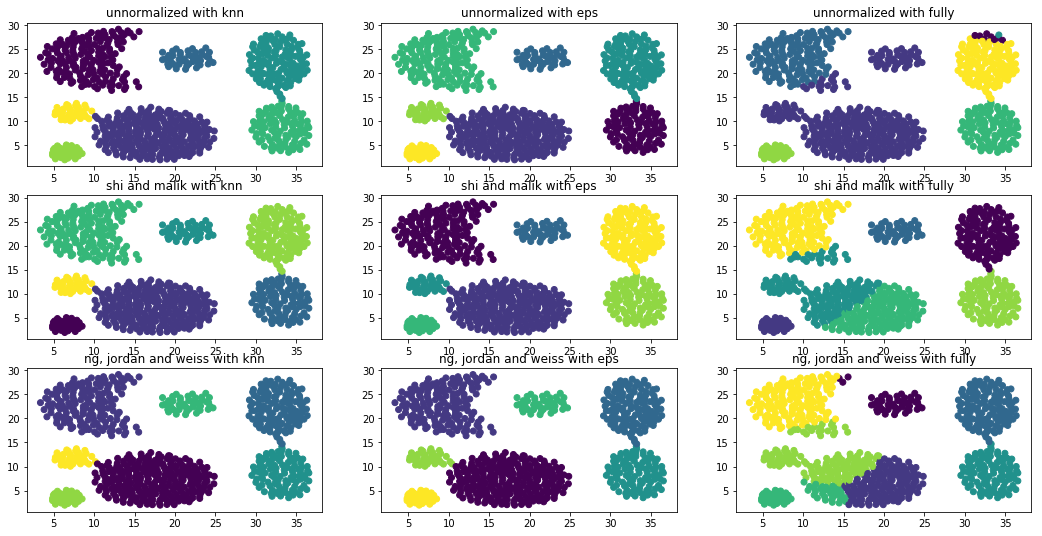

In [389]:
k = 7
eps = 0.80 #melhor parâmetro até agora
k_nn = 30 #melhor parâmetro até agora

results = []
experiments = [
    {'title':'unnormalized with knn','clusterization':unnormalized_spectral_clustering, 'k':k, 'build_graph':k_nearest_neighbor, 'parameter_graph':k_nn},
    {'title':'unnormalized with eps','clusterization':unnormalized_spectral_clustering, 'k':k, 'build_graph':eps_neighborhood, 'parameter_graph':eps},
    {'title':'unnormalized with fully','clusterization':unnormalized_spectral_clustering, 'k':k, 'build_graph':fully_connected, 'parameter_graph':None},
    {'title':'shi and malik with knn','clusterization':normalized_spectral_clustering_shi_malik, 'k':k, 'build_graph':k_nearest_neighbor, 'parameter_graph':k_nn},
    {'title':'shi and malik with eps','clusterization':normalized_spectral_clustering_shi_malik, 'k':k, 'build_graph':eps_neighborhood, 'parameter_graph':eps},
    {'title':'shi and malik with fully','clusterization':normalized_spectral_clustering_shi_malik, 'k':k, 'build_graph':fully_connected, 'parameter_graph':None},
    {'title':'ng, jordan and weiss with knn','clusterization':normalized_spectral_clustering_ng_jordan_weiss, 'k':k, 'build_graph':k_nearest_neighbor, 'parameter_graph':k_nn},
    {'title':'ng, jordan and weiss with eps','clusterization':normalized_spectral_clustering_ng_jordan_weiss, 'k':k, 'build_graph':eps_neighborhood, 'parameter_graph':eps},
    {'title':'ng, jordan and weiss with fully','clusterization':normalized_spectral_clustering_ng_jordan_weiss, 'k':k, 'build_graph':fully_connected, 'parameter_graph':None}
]

for e in experiments:
    matrix_similarity = euclidean_similarity(X.values)
    clusters = e['clusterization'](matrix_similarity, e['k'], e['build_graph'], e['parameter_graph'])
    #avaliação númerica do resultado
    print(e['title']+" = "+str(adjusted_rand_score(Y.tolist(),clusters.tolist())))
    results.append({'x':x, 'y':y, 'c':clusters.tolist(), 'title': e['title']}),

#avaliação vizual do resultado
plot(results,3,3)

#### Gabarito

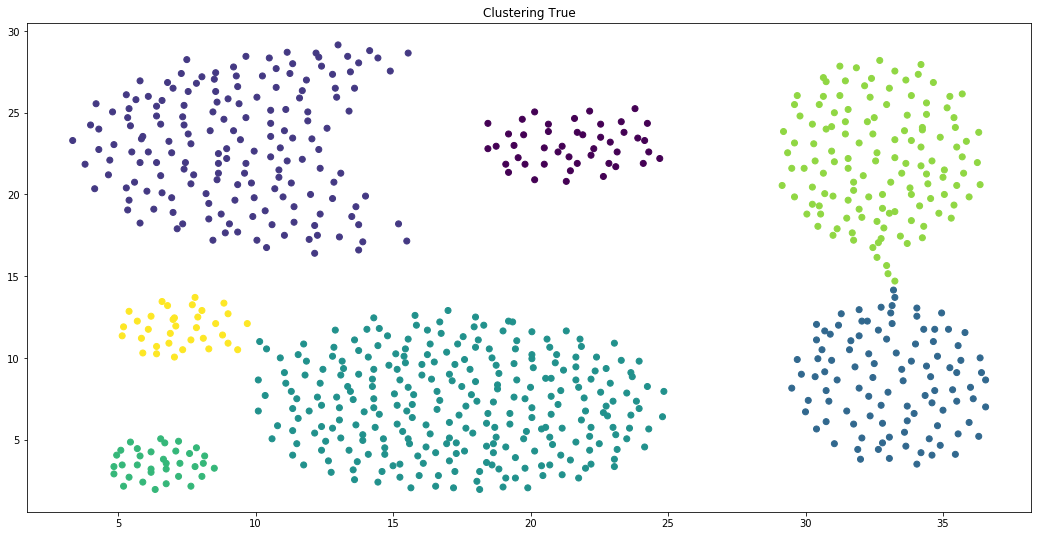

In [390]:
result_true = [
    {'x':x, 'y':y, 'c':Y.tolist(), 'title':'Clustering True'}
]
plot(result_true,1,1)

--------------------

#### Dataset Pulsar Star

In [393]:
X = pd.read_csv('predicting-a-pulsar-star/pulsar_stars.csv',sep=',')
Y = X['target_class']
X = X.drop(['target_class'], axis=1)

x_2d = TruncatedSVD(n_components=2).fit_transform(X)
x = np.matrix(x_2d)[:,0]
x = list(map(lambda v: v[0], x.tolist()))
y = np.matrix(x_2d)[:,1]
y = list(map(lambda v: v[0], y.tolist()))

In [394]:
matrix_similarity = cosine_similarity(X)

In [ ]:
k = 2
k_nn = 200
cluster = unnormalized_spectral_clustering(matrix_similarity,k, k_nearest_neighbor, k_nn)

print(adjusted_rand_score(Y.tolist(),clusters.tolist()))

In [ ]:
results = [
    {'x':x, 'y':y, 'c':clusters.tolist(), 'title':'Pred'}
    {'x':x, 'y':y, 'c':Y.tolist(), 'title':'True'}
]
plot(result,1,2)

---------------------_

#### Dataset Credit Card

In [9]:
dataset = pd.read_csv('ccdata/CC GENERAL.csv', sep=',')
dataset.CREDIT_LIMIT = dataset.CREDIT_LIMIT.fillna(20.000)
dataset.MINIMUM_PAYMENTS = dataset.MINIMUM_PAYMENTS.fillna(0)

cust_id = dataset.CUST_ID
dataset = dataset.drop(['CUST_ID'], axis=1)

In [23]:
X = np.matrix(dataset.values)
matrix_similarity = normalize(cosine_distances(X), norm='max')

In [24]:
k = 2
k_nn = 30
clusters = normalized_spectral_clustering_shi_malik(matrix_similarity, k, k_nearest_neighbor, k_nn)

knn - building D: 100%|██████████| 8950/8950 [00:48<00:00, 184.46it/s]


calculating eignvectors ...
clustering ...


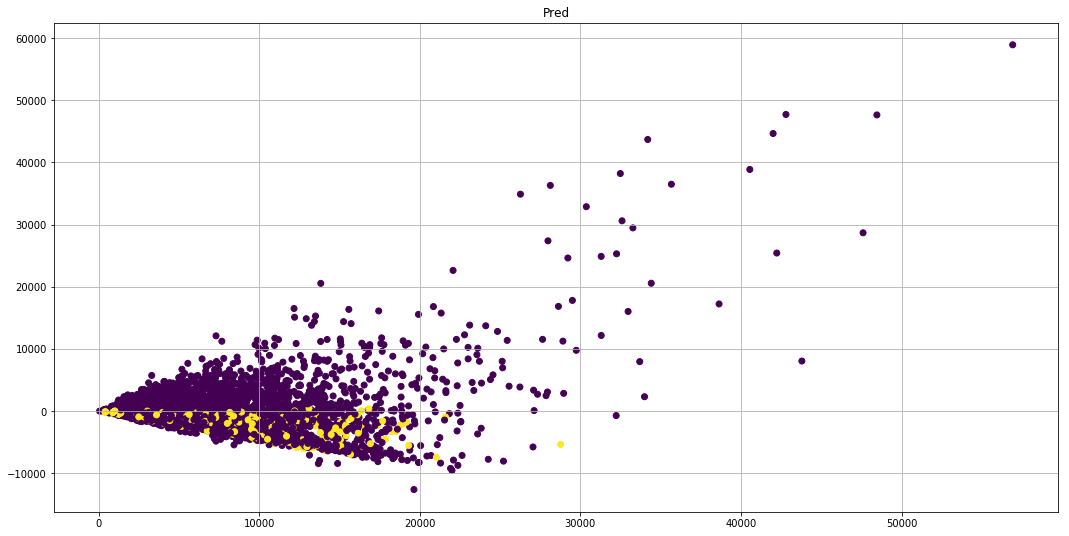

In [25]:
x_2d = TruncatedSVD(n_components=2).fit_transform(X)
x = np.matrix(x_2d)[:,0]
x = list(map(lambda v: v[0], x.tolist()))
y = np.matrix(x_2d)[:,1]
y = list(map(lambda v: v[0], y.tolist()))

result = [
    {'x':x, 'y':y, 'c':clusters.tolist(), 'title':'Pred'}
]
plot(result,1,1)

-------------------------

#### Dataset Dengue em Campinas

In [99]:
dataset = pd.read_csv('dengue-temperatura-e-chuvas-em-campinassp/dengue-dataset.csv', sep=',')

lb = LabelBinarizer()
datas_lb = lb.fit_transform(dataset.data)
dt_lb = pd.DataFrame(datas_lb, columns=lb.classes_)

dataset = dataset.drop(['data'], axis=1)
dataset = pd.concat([dataset,dt_lb], axis=1)
dataset.head()

,casos-confirmados,chuva,temperatura-media,temperatura-mininima,temperatura-maxima,1998-01-01,1998-02-01,1998-03-01,1998-04-01,1998-05-01,...,2014-03-01,2014-04-01,2014-05-01,2014-06-01,2014-07-01,2014-08-01,2014-09-01,2014-10-01,2014-11-01,2014-12-01
0,237,179.2,25.7,20.2,28.1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,331,226.3,25.1,20.0,28.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,562,149.1,24.8,22.4,27.2,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,187,46.4,22.7,18.1,26.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,32,88.3,19.2,15.7,22.9,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [108]:
dataset.chuva = dataset.chuva.fillna(dataset.chuva.mean())

In [115]:
x_2d = TruncatedSVD(n_components=2).fit_transform(dataset)
x = np.matrix(x_2d)[:,0]
x = list(map(lambda v: v[0], x.tolist()))
y = np.matrix(x_2d)[:,1]
y = list(map(lambda v: v[0], y.tolist()))

In [ ]:
k = 3
matrix_similarity = normalize(cosine_similarity(dataset), norm='max')
eps = matrix_similarity.mean()+3*matrix_similarity.std()
cluster_unnormalize_eps = unnormalized_spectral_clustering(matrix_similarity, k, eps_neighborhood, [eps, SIMILARITY])

matrix_similarity = normalize(cosine_similarity(dataset), norm='max')
clusters_shi_malik_eps = normalized_spectral_clustering_shi_malik(matrix_similarity, k, eps_neighborhood, [eps, SIMILARITY])

matrix_similarity = normalize(cosine_similarity(dataset), norm='max')
clusters_ng_jordan_weiss_eps = normalized_spectral_clustering_ng_jordan_weiss(matrix_similarity, k, eps_neighborhood, [eps, SIMILARITY])


k_nn = 25
matrix_similarity = normalize(cosine_similarity(dataset), norm='max')
cluster_unnormalize_knn = unnormalized_spectral_clustering(matrix_similarity, k, k_nearest_neighbor, [k_nn, SIMILARITY])

matrix_similarity = normalize(cosine_similarity(dataset), norm='max')
clusters_shi_malik_knn = normalized_spectral_clustering_shi_malik(matrix_similarity, k, k_nearest_neighbor, [k_nn, SIMILARITY])

matrix_similarity = normalize(cosine_similarity(dataset), norm='max')
clusters_ng_jordan_weiss_knn = normalized_spectral_clustering_ng_jordan_weiss(matrix_similarity, k, k_nearest_neighbor, [k_nn, SIMILARITY])


matrix_similarity = normalize(cosine_similarity(dataset), norm='max')
cluster_unnormalize_fully = unnormalized_spectral_clustering(matrix_similarity, k, fully_connected, [_, SIMILARITY])

matrix_similarity = normalize(cosine_similarity(dataset), norm='max')
clusters_shi_malik_fully = normalized_spectral_clustering_shi_malik(matrix_similarity, k, fully_connected, [_, SIMILARITY])

matrix_similarity = normalize(cosine_similarity(dataset), norm='max')
clusters_ng_jordan_weiss_fully = normalized_spectral_clustering_ng_jordan_weiss(matrix_similarity, k, fully_connected, [_, SIMILARITY])

results = [
    {'x':x, 'y':y, 'c':cluster_unnormalize_eps, 'title':'cluster_unnormalize_eps'},
    {'x':x, 'y':y, 'c':clusters_shi_malik_eps, 'title':'clusters_shi_malik_eps'},
    {'x':x, 'y':y, 'c':clusters_ng_jordan_weiss_eps, 'title':'clusters_ng_jordan_weiss_eps'},
    {'x':x, 'y':y, 'c':cluster_unnormalize_knn, 'title':'cluster_unnormalize_knn'},
    {'x':x, 'y':y, 'c':clusters_shi_malik_knn, 'title':'clusters_shi_malik_knn'},
    {'x':x, 'y':y, 'c':clusters_ng_jordan_weiss_knn, 'title':'clusters_ng_jordan_weiss_knn'},
    {'x':x, 'y':y, 'c':cluster_unnormalize_fully, 'title':'cluster_unnormalize_fully'},
    {'x':x, 'y':y, 'c':clusters_shi_malik_fully, 'title':'clusters_shi_malik_fully'},
    {'x':x, 'y':y, 'c':clusters_ng_jordan_weiss_fully, 'title':'clusters_ng_jordan_weiss_fully'}
]

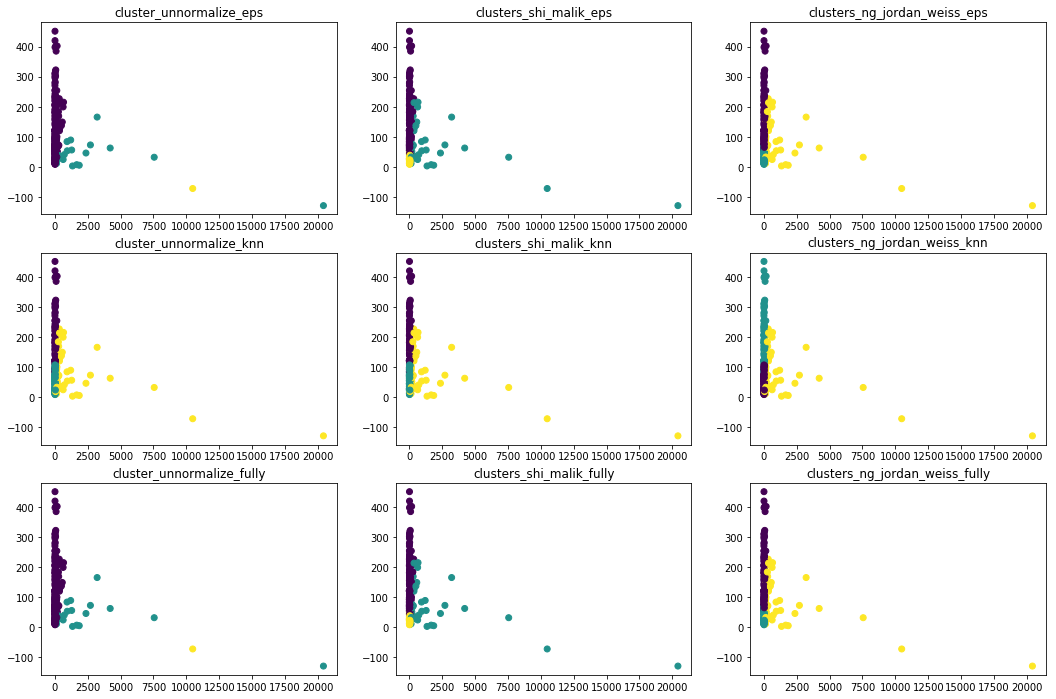

In [180]:
plot(results,3,3)